In [20]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

In [21]:
from tesseract_path import tesseract_cmd

print(tesseract_cmd)

pytesseract.pytesseract.tesseract_cmd = tesseract_cmd

C:\\Program Files\\Tesseract-OCR\\tesseract.exe


In [43]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        self.action_space = Discrete(3)
        self.cap = mss()
        self.game_location = { 'top': 300, 'left': 0,
                              'width': 600, 'height': 500 }
        self.done_location = { 'top': 375, 'left': 630,
                              'width': 660, 'height': 90 }

    def step(self, action):
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }

        if action != 2:
            pydirectinput.press(action_map[action])

        done, cap = self.get_done()
        new_obs = self.get_observation()
        reward = 1
        info = {}

        return new_obs, reward, done, False, info

    def render(self):
        pass

    def reset(self, seed=1):
        np.random.seed(seed)
        time.sleep(1)
        pydirectinput.click(x=850, y=150)
        pydirectinput.press('space')
        return self.get_observation(), {}

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        chanel = np.reshape(resized, (1, 83, 100))
        return chanel

    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_str = ['GAME', 'GAHE']

        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_str:
            done = True

        return done, done_cap

    def close(self):
        # just in case
        cv2.destroyAllWindows()

In [44]:
env = WebGame()

False


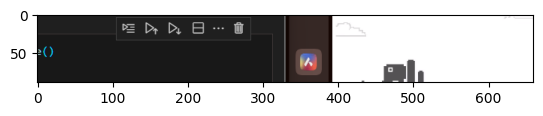

In [24]:
done, cap = env.get_done()
plt.imshow(cap)

In [25]:
env.action_space.sample()

1

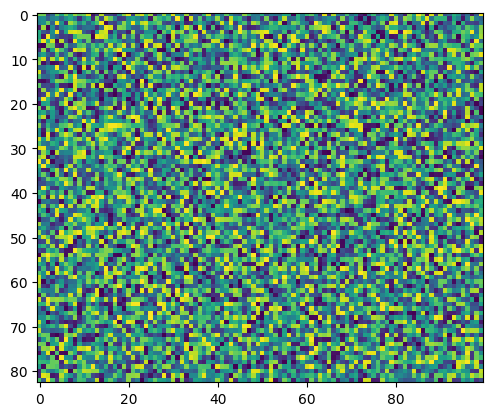

In [26]:
plt.imshow(env.observation_space.sample()[0])

In [29]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward)) 

Total Reward for episode 0 is 13
Total Reward for episode 1 is 13
Total Reward for episode 2 is 10
Total Reward for episode 3 is 14
Total Reward for episode 4 is 11
Total Reward for episode 5 is 10
Total Reward for episode 6 is 13
Total Reward for episode 7 is 13
Total Reward for episode 8 is 11
Total Reward for episode 9 is 15


In [30]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [45]:
env_checker.check_env(env)

In [48]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [49]:
CHECKPOINT = './train/'
LOG = './logs/'

In [50]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT)

In [51]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [54]:
model = DQN('CnnPolicy', env, verbose=1,
            buffer_size=300000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Python311\Lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 4.98GB > 1.18GB
  warnings.warn(


In [56]:
model.learn(total_timesteps=2000, callback=callback)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.786    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 28       |
|    total_timesteps  | 45       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.1     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.577    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 54       |
|    total_timesteps  | 89       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.383    |
| time/               |          |
|    episodes       